# ideas for this notebook:

1. Logistic Regression for classification with TensorFlow
2. Random Forest for classification with TensorFlow
3. Gradient Boosted Trees for classification with TensorFlow  

compare the three methods

## *1. Setup*
#### import the modules and load the data

In [111]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

import os

'''
If you are in Kaggle:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nIf you are in Kaggle:\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [112]:
# import modules
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from matplotlib import pyplot as plt
import seaborn as sns

# options for pandas display, show only three decimals
pd.options.display.float_format = "{:.3f}".format 

In [113]:
# get the data

# If you are in Kaggle:
# train_df = pd.read_csv("/kaggle/input/titanic/train.csv")

# If you downloaded all the files:
train_df = pd.read_csv("input/train.csv")

# shuffle the train dataset to avoid tendencies
traind_df = train_df.reindex(np.random.permutation(train_df.index))

train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000,0,0,211536,13.000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000,0,0,112053,30.000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.450,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000,0,0,111369,30.000,C148,C


In [114]:
# If you are at Kaggle:
#test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

# If you downloaded all the files:
test_df = pd.read_csv("input/test.csv")

test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.050,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000,0,0,PC 17758,108.900,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500,0,0,SOTON/O.Q. 3101262,7.250,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.050,NaN,S


## *2. Exploratory Data Analysis (EDA)*
#### visualize the data, found possible errors in it, missing values, looks for hints for the better features, ... 

In [115]:
# concatenate train and test sets
df = pd.concat([train_df, test_df], axis=0) 
df

# some visualization of the dataset
# print("df info:")
# print()
# df.info()
# print()

print("null values count:")
print()
df.isnull().sum()


null values count:



PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Analysis:

so we have missing values for:

1. Age (263, about 20%), can be a good feature, we will need to treat this missing values. 
2. Fare (only 1), we will fill this data and will have no problem, it is only one.
3. Cabin (most of the values, more than 75%), difficult to fill with veracity when more than 75% of the values are missing.
4. Embarked (only 2), we will fill this data and will have no problem, it is only one.

In [116]:
# list with the names of numerical and categorical columns
numerical_columns = ['PassengerId', 'Survived', 'Pclass', 'Fare', 'Age', 'SibSp', 'Parch']
categorical_columns = [x for x in df.columns if x not in numerical_columns]  

# print the .describe() with all de column types
print("data describe:")
print()
df[numerical_columns + categorical_columns].describe(include="all").T


data describe:



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,1309.000,NaN,NaN,NaN,655.000,378.020,1.000,328.000,655.000,982.000,1309.000
Survived,891.000,NaN,NaN,NaN,0.384,0.487,0.000,0.000,0.000,1.000,1.000
Pclass,1309.000,NaN,NaN,NaN,2.295,0.838,1.000,2.000,3.000,3.000,3.000
Fare,1308.000,NaN,NaN,NaN,33.295,51.759,0.000,7.896,14.454,31.275,512.329
Age,1046.000,NaN,NaN,NaN,29.881,14.413,0.170,21.000,28.000,39.000,80.000
SibSp,1309.000,NaN,NaN,NaN,0.499,1.042,0.000,0.000,0.000,1.000,8.000
Parch,1309.000,NaN,NaN,NaN,0.385,0.866,0.000,0.000,0.000,0.000,9.000
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ticket,1309,929,CA. 2343,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Analysis:

1. 38,4% of the people survived (not very imbalanced) (the .describe() doesn't count the NaN's when calculating the average)
2. 843 males vs 466 female (a little imbalanced)
3. SibSp and Parch max of 8 and 9 respectively, which is kind of ok considering [the average number of childrens were greater](https://populationeducation.org/wp-content/uploads/2020/04/average-number-children-per-us-family-historic-infographic.pdf) but most people had no (or few) relatives on board, we can see this by the quantiles 4.186 unique cabins (of only 295 values, can't categorize by this feature)

Questions:
1. minimum fare of 0 (15 values)? no explanation for this in the dataset description
2. the tickets aren't unique for each person, the same family members get the same ticket? no explanation for this in the dataset description 

Not really, sometimes yes sometimes not, better do this by the name of the family

/Users/pedromariano/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

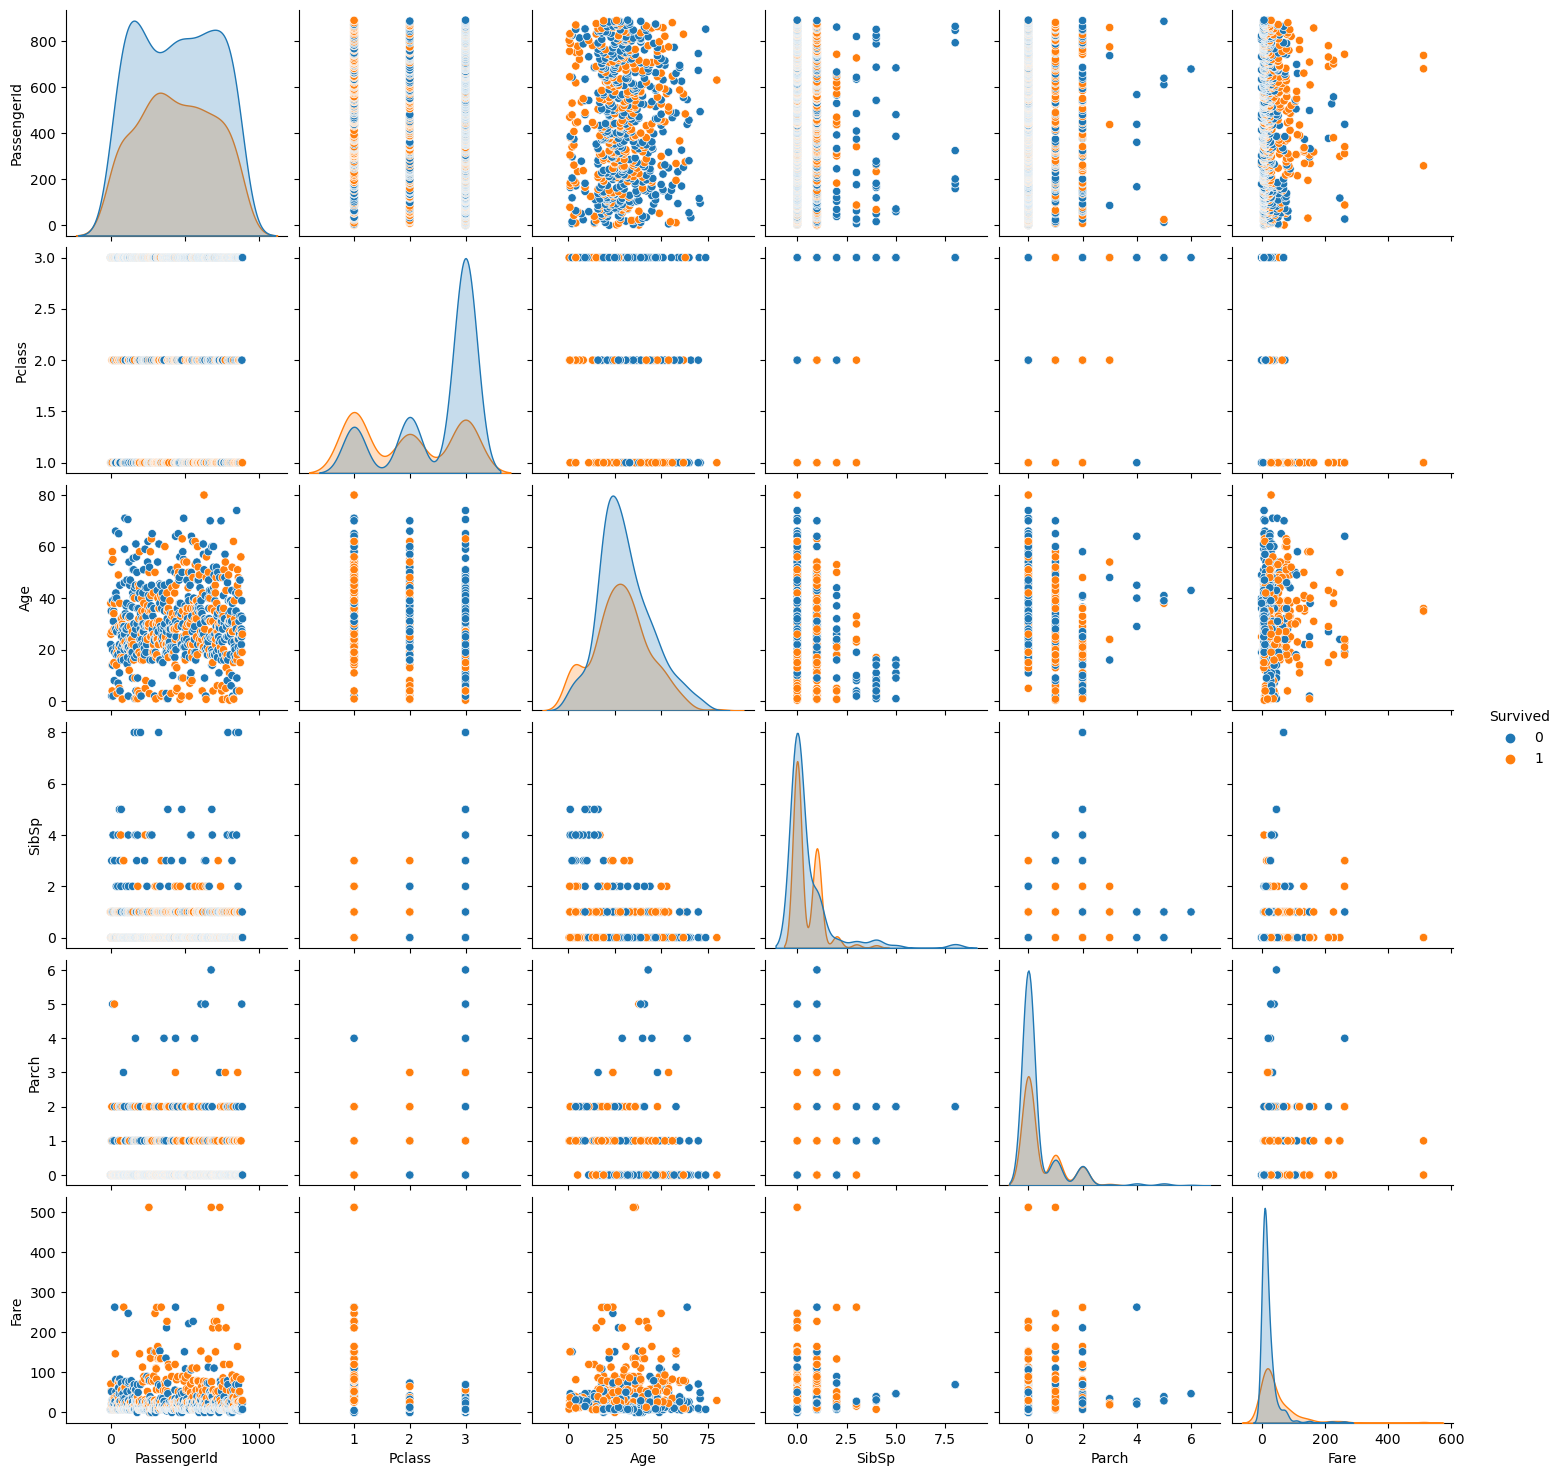

In [117]:
# visualization of distributions
# here we use only the train dataframe because we need the 
# Survived values
plt.figure()
sns.pairplot(train_df, hue="Survived")


Analysis:

1. most people from the Pclass=3 died than lived, in Pclass=1,2 the number is alike

2. high (4 or more) SibSp or Parch seems to have died more 

3. none of the other distributions seem to indicate a clear line between the people that survived and those who didn't in other words, do not show trends of people who survived in function of the features (or a relantionship between features and survived) 

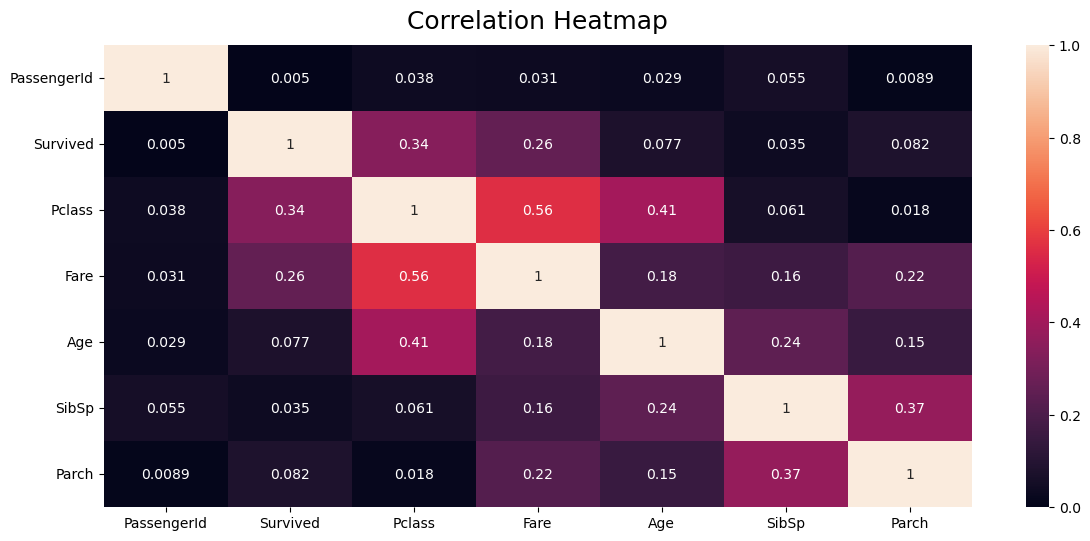

In [118]:
# visualization of correlations
plt.figure(figsize=(14, 6))
heatmap_df = df[['PassengerId', 'Survived', 'Pclass', 'Fare', 'Age', 'SibSp', 'Parch']]
#mask = np.triu(np.ones_like(heatmap_df.corr(), dtype=bool))
heatmap = sns.heatmap(heatmap_df.corr().abs(), vmin=0, vmax=1, annot=True);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Analysis:

we dont have much correlation in the dataset

The most useful one is the 0.34 in Survived x Pclass and it's not great

In [119]:
# to show all the dataframes
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# check if the data are imbalanced

# male and female who survived
df_temp1 = train_df.groupby(['Sex','Survived'],as_index=False).size().rename(columns={"size":'counts'})

# Pclass (ticket class) and their survival
df_temp2 = train_df.groupby(['Pclass','Survived'],as_index=False).size().rename(columns={"size":'counts'})

# SibSp (siblings and spouses) and their survival
df_temp3 = train_df.groupby(['SibSp','Survived'],as_index=False).size().rename(columns={"size":'counts'})

# Parch (parents and childrens) and their survival
df_temp4 = train_df.groupby(['Parch','Survived'],as_index=False).size().rename(columns={"size":'counts'})

# SibSp + Parch and their survival
df_temp4 = train_df.groupby(['Parch','Survived'],as_index=False).size().rename(columns={"size":'counts'})

display_side_by_side(df_temp1,df_temp2,df_temp3,df_temp4, titles=['Sex-Survived','Pclass-Survived',"SibSp-Survived","Parch-Survived"])

,Sex,Survived,counts
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109
,Pclass,Survived,counts
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372


Check if the data are imbalanced comparing who survived and who not in each category.

Analysis:

1. most female survived while most men died, good feature.
2. the number is kind of equal except for the 3 Pclass where more people died and a little for the 1 Pclass.
3. not much difference of counts in the same values of SibSp, except for zero, where more people died.
4. in Parch=0 more people die (2/3) for others Parch's there is not much difference
5. in Parch=0 more people die (2/3) for others Parch's there is not much difference


## *2.2 Data Preprocessing*

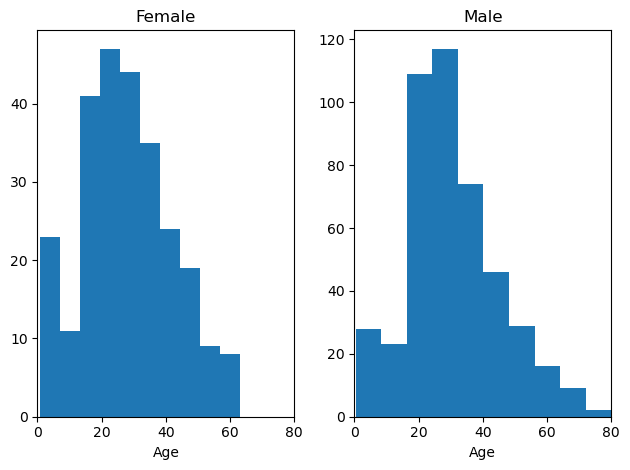

In [120]:
# check if age has a correlation with sex

# group by sex and age
df_temp = train_df.groupby(['Sex','Age'],as_index=False).size().rename(columns={"size":'counts'})

# histogram of age divided by sex
plt.subplot(1, 2, 1)
plt.hist(df_temp[df_temp["Sex"]=="female"]["Age"], weights=df_temp[df_temp["Sex"]=="female"]["counts"] )
plt.title("Female")
plt.xlim(0,80)
plt.xlabel("Age")
plt.subplot(1, 2, 2)
plt.hist(df_temp[df_temp["Sex"]=="male"]["Age"], weights=df_temp[df_temp["Sex"]=="male"]["counts"] )
plt.title("Male")
plt.xlim(0,80)
plt.xlabel("Age")
plt.tight_layout()
plt.show()

Treat the data:

1. Fill the NaN's in age. Pclass has a correlation of 0.41 with age, sex seems to have low correlation, we will group by Pclass. Creates a dataframe grouped by Pclass with the mean of Age for each Pclass (contains columns Mean Age, Pclass and others)
3. Normalize the Fare column
4. Creates a column with the total family size

Show the data.

In [121]:
# 1. 
# group by Pclass
df_temp = df[['Pclass','Age']].groupby("Pclass", as_index=False).mean().rename(columns={"Age":"Mean Age"})

# creates a dictionary from Pclass to medium age
dict_temp = dict(zip(df_temp["Pclass"], df_temp["Mean Age"]))

# fill the nan's mapping the dictionary 
df["Age"] = df["Age"].fillna(df["Pclass"].map(dict_temp))


# 2. 
# then normalize the fare column by the Z-score
# df["Fare"] = ( df["Fare"]-df["Fare"].mean() ) / df["Fare"].std() 

# then normalize the fare column between 0 and 1
df["Fare"] = df["Fare"] / df["Fare"].max()

# 3.
# creates a new column in the dataframe with the family size 
df["FamilySize"] = df["SibSp"] + df["Parch"]

# the filled df
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.000,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,0.014,NaN,S,1
1,2,1.000,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,0.139,C85,C,1
2,3,1.000,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,0.015,NaN,S,0
3,4,1.000,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,0.104,C123,S,1
4,5,0.000,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,0.016,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,24.816,0,0,A.5. 3236,0.016,NaN,S,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000,0,0,PC 17758,0.213,C105,C,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500,0,0,SOTON/O.Q. 3101262,0.014,NaN,S,0
416,1308,NaN,3,"Ware, Mr. Frederick",male,24.816,0,0,359309,0.016,NaN,S,0


In [122]:
# null values
print("null values count:")
print()
df.isnull().sum()

null values count:



PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
FamilySize        0
dtype: int64

As said, Cabin has most of the values missing, more than 75%. So it is difficult to fill with veracity when more than 75% of the values are missing.

But now Age is done.

In [123]:
# split the data back in train and test sets after treated
train_df_treated = df.iloc[:890]
test_df_treated = df.iloc[891:].drop(["Survived"], axis=1)
# removed the survived column from test set

## *3. Building and comparing three diferent ML models*
### 3.1 Logistic Regression - TensorFlow
### 3.2 Random Forests - TensorFlow
### 3.3 Gradient Boosted Trees - TensorFlow

### *3.1 Logistic Regression - TensorFlow*

#### heavily based on the Google ML Crash Course

In [124]:
# creates the feature layer

# list with the name of the numerical features
list_numerical_features = ["Fare"]

# list with the name of the bucketized features
list_bucketized_features = ["Age", "FamilySize"]

# dictionary with resolution of intervals of each 
# bucketized feature
dict_bucketized_features = {"Age":10, "FamilySize":2}

# list with categorical features  
list_categorical_features = ["Sex", "Pclass"]

# dictionary with vocabulary of each categorical feature
dict_categorical_features = {"Sex":["male","female"], "Pclass":[1,2,3]}



# join all the features
list_features = []
list_features.extend(list_numerical_features[:])
list_features.extend(list_bucketized_features[:])
list_features.extend(list_categorical_features[:])

# list with the feature columns
feature_columns = []


# creates the feature columns

# create numerical feature columns
for name in list_numerical_features:
    feature_columns.append(tf.feature_column.numeric_column(name))
    
# create bucketized feature columns
for name in list_bucketized_features:
    numeric = tf.feature_column.numeric_column(name)
    boundaries = list(np.arange( int(min(df[name])), int(max(df[name])), dict_bucketized_features[name] ))
    bucketized_feature = tf.feature_column.bucketized_column(numeric, boundaries=boundaries)
    feature_columns.append(bucketized_feature)
    
# create categorical feature columns
for name in list_categorical_features:    
    categorical_feature = tf.feature_column.categorical_column_with_vocabulary_list(key=name, vocabulary_list=dict_categorical_features[name], default_value=0)
    embedded_group_column = tf.feature_column.embedding_column(categorical_feature,dimension=len(dict_categorical_features[name]))
    feature_columns.append(embedded_group_column)
    

# shows the feature columns to see if everything is allright
print(feature_columns)
    
# finally
# convert the features into a layer
feature_layer = layers.DenseFeatures(feature_columns)

[NumericColumn(key='Fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), BucketizedColumn(source_column=NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0, 10, 20, 30, 40, 50, 60, 70)), BucketizedColumn(source_column=NumericColumn(key='FamilySize', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(0, 2, 4, 6, 8)), EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=0, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x2a1d103d0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True), EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=0, num_oov_buckets=0), dimension=

In [125]:
# functions that create and train a model

# classification model
def Create_Model(learning_rate, feature_layer, metrics):
    
    # sequential model
    model = tf.keras.models.Sequential()
    
    # add the feature layer we created
    model.add(feature_layer)
    
    # pass the regression value trough a sigmoid activation
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation=tf.sigmoid))
    
    # compile into a model that tensorflow can execute with a 
    # Binary Cross Entropy loss function
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate), 
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=metrics)
    
    return model


# train the model
def Train_Model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
    
    # create dict with name of the features and numpy arrays of 
    # its values for each feature
    features = {name:np.array(value) for name, value in dataset.items()}
    
    # removes the label from features and puts it into variable 
    # label
    label = np.array(features.pop(label_name))
    
    # trains the model for a fixed number of epochs
    history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=1)
    
    # the list of epochs
    epochs_list = history.epoch
    
    # classification metrics (training loss values and metric 
    # values [and validation if applicable]) for each epoch
    classification_metrics_history = pd.DataFrame(history.history)
    
    return epochs_list, classification_metrics_history

In [126]:
# defines the plotting function 

def Plot_Curve(epochs_list, classification_metrics_history, list_of_metrics):
    #plot the curves of one or more classification metrics 
    # vs epoch
    # list_of_metrics should be one of the [names here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics)
    
    plt.figure()
    plt.xlabel("epoch")
    plt.ylabel("Value")
    
    for metric in list_of_metrics:
        x = classification_metrics_history[metric]
        plt.plot(epochs_list[1:], x[1:], label=metric)
        
    plt.legend()

Epoch 1/100


/Users/pedromariano/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 [==============================] - 0s 892us/step - loss: 0.7197 - accuracy: 0.6315 - precision: 0.5833 - recall: 0.1433 - auc: 0.5880
Epoch 2/100
9/9 [==============================] - 0s 782us/step - loss: 0.6624 - accuracy: 0.6180 - precision: 1.0000 - recall: 0.0058 - auc: 0.6986
Epoch 3/100
9/9 [==============================] - 0s 910us/step - loss: 0.6240 - accuracy: 0.6157 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7615
Epoch 4/100
9/9 [==============================] - 0s 960us/step - loss: 0.5938 - accuracy: 0.6146 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8007
Epoch 5/100
9/9 [==============================] - 0s 880us/step - loss: 0.5688 - accuracy: 0.6236 - precision: 0.8889 - recall: 0.0234 - auc: 0.8174  
Epoch 6/100
9/9 [==============================] - 0s 876us/step - loss: 0.5476 - accuracy: 0.6708 - precision: 0.9804 - recall: 0.1462 - auc: 0.8318
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: 0.5287 - accuracy: 0.68

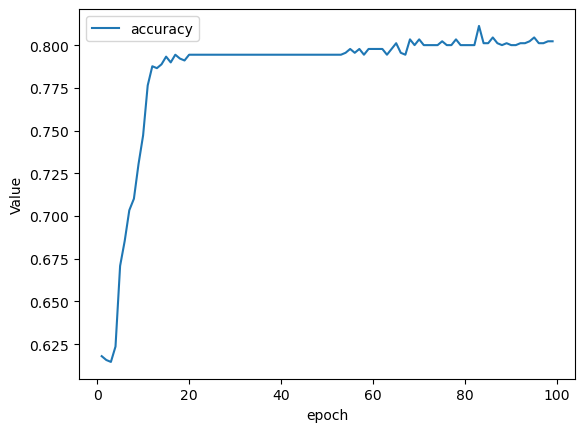

In [127]:
# Set the hyperparameters, train the model and plot the 
# result of training

# hyperparameters 

# output values above the classification_threshold will 
# be considered as survived (1), below as dead (0)
classification_threshold = 0.65
# the multiplication factor of the gradient update
learning_rate = 0.005
# how many iterations over the whole datset
epochs = 100
# number of iterations (values) before gradient calculation 
# and update
batch_size = 100

# creates the label name
label_name = "Survived"

# the metrics the model will measure
metrics = [tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=classification_threshold),
           tf.keras.metrics.Precision(name="precision", thresholds=classification_threshold),
           tf.keras.metrics.Recall(name="recall", thresholds=classification_threshold),
           tf.keras.metrics.AUC(name="auc", num_thresholds=100),
          ]

# creates the model 
model = Create_Model(learning_rate, feature_layer, metrics)

# dataframe with only the columns we will use
df_temp = pd.concat([train_df_treated[list_features], train_df_treated[label_name]], axis=1)

# train the model on the training set
epochs_list, classification_metrics_history = Train_Model(model, df_temp, epochs, label_name, batch_size)

# plot the graphs of the chosen metrics vs epochs 
list_of_metrics_to_plot = ["accuracy"]
Plot_Curve(epochs_list, classification_metrics_history, list_of_metrics_to_plot)

In [128]:
# evaluate the model against the test set

# create a dict with name of the features and numpy arrays 
# of its values - of the test set
features = {name:np.array(value) for name, value in test_df_treated[list_features].items()}

# if you have a test set with label:
# separates the label
# label = np.array(features.pop(label_name))
# evaluate the model
# model.evaluate(x=features, y=label, batch_size=batch_size)

# if you have a test set without label (our case) and has to 
# make predictions:
predictions = model.predict(x=features, batch_size=batch_size) # numpy array

# transform into 0's and 1's according to the classification 
# threshold  
predictions = (predictions > classification_threshold).astype(int)

# check if there are any problems (Nan's)
if np.sum(np.isnan(predictions))==0:
    print("Zero NaN's")
else:
    print("There are {} NaN's".format(np.sum(np.isnan(predictions))) )

5/5 [==============================] - 0s 665us/step
Zero NaN's


In [129]:
# creates the submission file

# gets the PassengerId column of the test data
passengerid_df = pd.DataFrame(test_df_treated["PassengerId"], columns=["PassengerId"])
# transforms predicions into dataframe
predictions_df = pd.DataFrame(predictions, columns=["Survived"])

# join in one dataframe with two columns
submission_df = pd.concat([passengerid_df, predictions_df], axis=1)

# checks again if everything is alright
print(submission_df)

# save the predictions into a csv file
submission_df.to_csv("output/TitanicPredictions_LogisticRegression_TF.csv", index=False, sep=",")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


#### *3.1.2 Logistic Regression - TensorFlow*
#### Results

This model ended up with accuracy = 0.7933, loss = 0.6273, precision = 0.9438, recall = 0.4912, auc = 0.8022.

This model used only 5 columns of the 13 available in the data.

After submitting to Kaggle these predictions get an Score of 0.54545

### *4.2 Random Forest - TensorFlow*

#### Now use the second method, Random Forests

In [130]:
# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df_treated, label="Survived")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df_treated)

In [131]:
# TF-DF supports all these feature types (numerical, categorical, 
# ...) natively (differently than NN based models), 

# therefore there is no need for preprocessing in the form of 
# one-hot encoding, normalization or extra is_present feature.

# Labels are a bit different: Keras metrics expect integers. 
# Which is no problem in the Titanic case.

# Train a Random Forest model.
model_rf = tfdf.keras.RandomForestModel(verbose=0)
fitting = model_rf.fit(train_ds)

# Calling compile on the model before the fit is optional. 
# Compile can be used to provide extra evaluation metrics.

[INFO 23-12-21 12:39:59.1252 -03 kernel.cc:1233] Loading model from path /var/folders/sh/sl12j2b121s3_7_yj1tdcghw0000gn/T/tmpjnz9ukmb/model/ with prefix 9f34f4dd30a5408a
[INFO 23-12-21 12:39:59.1819 -03 decision_forest.cc:660] Model loaded with 300 root(s), 44430 node(s), and 10 input feature(s).
[INFO 23-12-21 12:39:59.1819 -03 abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-12-21 12:39:59.1820 -03 kernel.cc:1061] Use fast generic engine


In [132]:
'''
Other options to analyze the model:

Summary of the model structure to see:

- Type: The learning algorithm used to train the model 
(Random Forest in our case).
- Task: The problem solved by the model (Classification in 
our case).
- Input Features: The input features of the model.
- Variable Importance: Different measures of the importance 
of each feature for the model.
- Out-of-bag evaluation: The out-of-bag evaluation of the model. 
This is a cheap and efficient alternative to cross-validation.
- Number of {trees, nodes} and other metrics: Statistics about 
the structure of the decisions forests.
'''

model_rf.summary()


# Evaluate the model against a test set (that means, 
# dataset not used in training and with label):

# model_1.compile(metrics=["accuracy"])
# evaluation = model_rf.evaluate(test_ds, return_dict=True)
# print()
# for name, value in evaluation.items():
#   print(f"{name}: {value:.4f}")


# to plot the trees diagram to visualize the decision nodes 
# and the information gain:
# tfdf.model_plotter.plot_model_in_colab(model_rf, tree_idx=0, 
#                                        max_depth=3)

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (12):
	Age
	Cabin
	Embarked
	FamilySize
	Fare
	Name
	Parch
	PassengerId
	Pclass
	Sex
	SibSp
	Ticket

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.         "Sex"  0.491489 ################
    2.        "Fare"  0.259640 ######
    3.         "Age"  0.219760 ####
    4.      "Pclass"  0.211266 ####
    5. "PassengerId"  0.167881 ##
    6.      "Ticket"  0.143366 #
    7.  "FamilySize"  0.135945 #
    8.    "Embarked"  0.127871 
    9.       "Parch"  0.113315 
   10.       "SibSp"  0.111682 

Variable Importance: NUM_AS_ROOT:
    1.        "Sex" 152.000000 ################
    2.  

In [133]:
# The model have an accuracy of 0.830337 in the training set

In [134]:
# The feature importances (we can see this in the summary as well)
# model_rf.make_inspector().variable_importances()

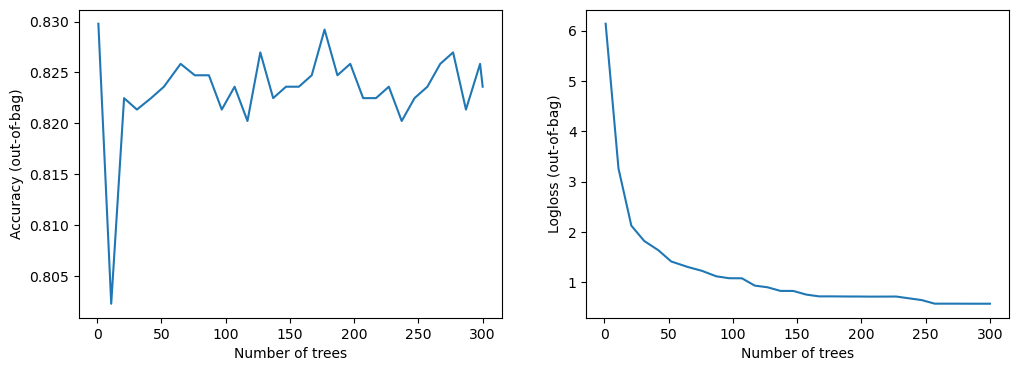

In [135]:
# See the balance between model size and model quality

logs = model_rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [136]:
# make predictions about the test set of Titanic wich 
# has no labels:

# if you have a test set without label (our case) and has 
# to make predictions:
predictions_rf = model_rf.predict(test_ds) # numpy array

# transform into 0's and 1's according to the classification 
# threshold  
predictions_rf = (predictions_rf > classification_threshold).astype(int)

# check if there are any problems (Nan's)
if np.sum(np.isnan(predictions_rf))==0:
    print("Zero NaN's")
else:
    print("There are {} NaN's".format(np.sum(np.isnan(predictions_rf))) )

1/1 [==============================] - 0s 29ms/step
Zero NaN's


In [137]:
# creates the submission file

# gets the PassengerId column of the test data
passengerid_df = pd.DataFrame(test_df_treated["PassengerId"], columns=["PassengerId"])
# transforms predicions into dataframe
predictions_df = pd.DataFrame(predictions_rf, columns=["Survived"])

# join in one dataframe with two columns
submission_df = pd.concat([passengerid_df, predictions_df], axis=1)

# checks again if everything is alright
print(submission_df)

# save the predictions into a csv file
submission_df.to_csv("output/TitanicPredictions_RandomForest_TF.csv", index=False, sep=",")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


#### *3.2.2 Random Forests - TensorFlow*
#### Results

This model ended up with number of trees equal to 300, accuracy = 0.830337, logloss = 0.534503.

It could be downgraded to about 150 trees where after that number the logloss and the accuracy doesn't change much.

This model used all the 13 columns of data.

After submitting to Kaggle these predictions get an Score of 0.78708

### *4.3 Gradient Boosted Trees - TensorFlow*

#### Now use the third method, Gradient Boosted Trees (GBT)

In [138]:
# Train a Gradient Boosted Trees model.
model_gbt = tfdf.keras.GradientBoostedTreesModel(verbose=0)
fitting = model_gbt.fit(train_ds)

# Calling compile on the model before the fit is optional. 
# Compile can be used to provide extra evaluation metrics.

[WARNING 23-12-21 12:39:59.4023 -03 gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-12-21 12:39:59.4023 -03 gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-12-21 12:39:59.4023 -03 gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 23-12-21 12:39:59.5863 -03 kernel.cc:1233] Loading model from path /var/folders/sh/sl12j2b121s3_7_yj1tdcghw0000gn/T/tmpe0oprvp1/model/ with prefix 553699eca02045ee
[INFO 23-12-21 12:39:59.5879 -03 kernel.cc:1061] Use fast generic engine


In [139]:
# Check the Summary of the GBT model.
model_gbt.summary()

# Type: The learning algorithm used to train the model 
# (Random Forest in our case).

# Task: The problem solved by the model (Classification 
# in our case).

# Input Features: The input features of the model.

# Variable Importance: Different measures of the importance 
# of each feature for the model.

# Out-of-bag evaluation: The out-of-bag evaluation of the model. 
# This is a cheap and efficient alternative to cross-validation.

# Number of {trees, nodes} and other metrics: Statistics about 
# the structure of the decisions forests.

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (12):
	Age
	Cabin
	Embarked
	FamilySize
	Fare
	Name
	Parch
	PassengerId
	Pclass
	Sex
	SibSp
	Ticket

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.         "Sex"  0.884393 ################
    2.      "Pclass"  0.271642 ##
    3.         "Age"  0.251440 #
    4.        "Fare"  0.245208 #
    5. "PassengerId"  0.215269 
    6.      "Ticket"  0.209240 
    7.  "FamilySize"  0.187521 
    8.    "Embarked"  0.184520 
    9.       "SibSp"  0.180812 
   10.       "Parch"  0.177492 

Variable Importance: NUM_AS_ROOT:
    1.    "Sex" 26.000000 ################
    2. "T

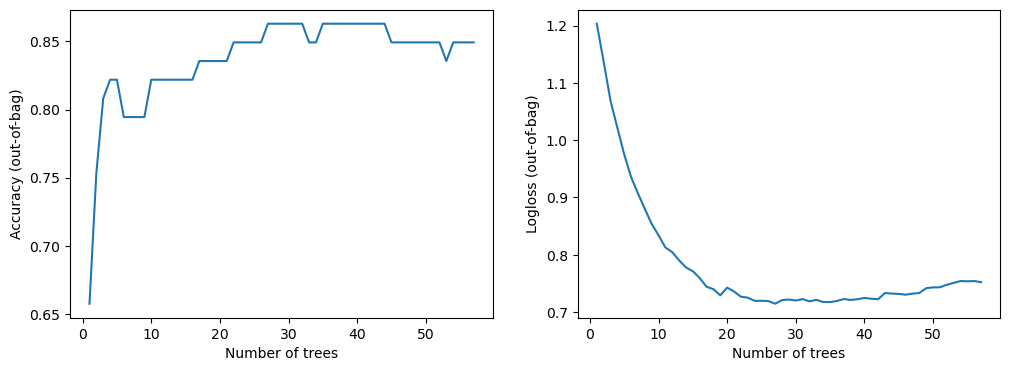

In [140]:
# See the balance between model size and model quality

logs = model_gbt.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# it seems to have an overfitting at 20 trees.
# the accuracy doesn't change much after that as well

In [141]:
# make predictions about the test set of Titanic 
# which has no labels:

# if you have a test set without label (our case) 
# and has to make predictions:
predictions_gbt = model_gbt.predict(test_ds) # numpy array

# transform into 0's and 1's according to the classification 
# threshold  
predictions_gbt = (predictions_gbt > classification_threshold).astype(int)

# check if there are any problems (Nan's)
if np.sum(np.isnan(predictions_gbt))==0:
    print("Zero NaN's")
else:
    print("There are {} NaN's".format(np.sum(np.isnan(predictions_gbt))) )

1/1 [==============================] - 0s 21ms/step
Zero NaN's


In [142]:
# creates the submission file

# gets the PassengerId column of the test data
passengerid_df = pd.DataFrame(test_df_treated["PassengerId"], columns=["PassengerId"])
# transforms predicions into dataframe
predictions_df = pd.DataFrame(predictions_gbt, columns=["Survived"])

# join in one dataframe with two columns
submission_df = pd.concat([passengerid_df, predictions_df], axis=1)

# checks again if everything is alright
print(submission_df)

# save the predictions into a csv file
submission_df.to_csv("output/TitanicPredictions_GradientBoostedTrees_TF.csv", index=False, sep=",")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


#### *3.3.2 Gradient Boosted Trees - TensorFlow*
#### Results

This model ended up with number of trees equal to 23, valid-loss = 0.691526, valid accuracy = 0.835616.

This shows that in fact it doesn't make sense to use more than 20 and so trees as i mentioned after the Logloss graph.

This model used all the 13 columns of data.

After submitting to Kaggle these predictions get an Score of 0.78468 an ended up in place 1602 of 15192 people.